In [49]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import scipy.stats as stats
from great_tables import GT, style, loc, md
import seaborn as sns

In [50]:
files = os.listdir('baseline_merged')
files = [file for file in files if file.endswith('.csv')]

baseline_merged = pd.concat([pd.read_csv(f'baseline_merged/{file}') for file in files])
baseline_merged.dropna(subset='recc_rate', inplace=True)

baseline_merged=baseline_merged[~baseline_merged['User'].isin(['Nathan Worrell','Liam Jagrowski','Henry Cross','Dylan Orr','Jacob Swain','John Hazelton','Brian Dietrich'])]

baseline_merged['InputtedRent'] = baseline_merged['InputtedRent'].str.replace(',','').astype(float)
baseline_merged['RecommendationDate'] = pd.to_datetime(baseline_merged['RecommendationDate'])

AssetDetailActive = pd.read_csv('data/vw_AssetDetailActive.csv')

baseline_merged = baseline_merged.merge(AssetDetailActive, on='AssetName')

baseline_merged['Diff'] = baseline_merged['InputtedRent'] - baseline_merged['recc_rate']

In [51]:
baseline_merged['accepted'] = abs(baseline_merged['InputtedRent'] - baseline_merged['recc_rate']) < 1
baseline_merged['accepted_range'] = (baseline_merged['InputtedRent'] >= baseline_merged['recc_rate_lower']) & (baseline_merged['InputtedRent'] <= baseline_merged['recc_rate_upper'])

rejections = baseline_merged[~baseline_merged['accepted']]
rejections['increase'] = rejections['Diff'] > 0
rejections['decrease'] = rejections['Diff'] < 0

C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_10224\326457472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['increase'] = rejections['Diff'] > 0
C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_10224\326457472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['decrease'] = rejections['Diff'] < 0


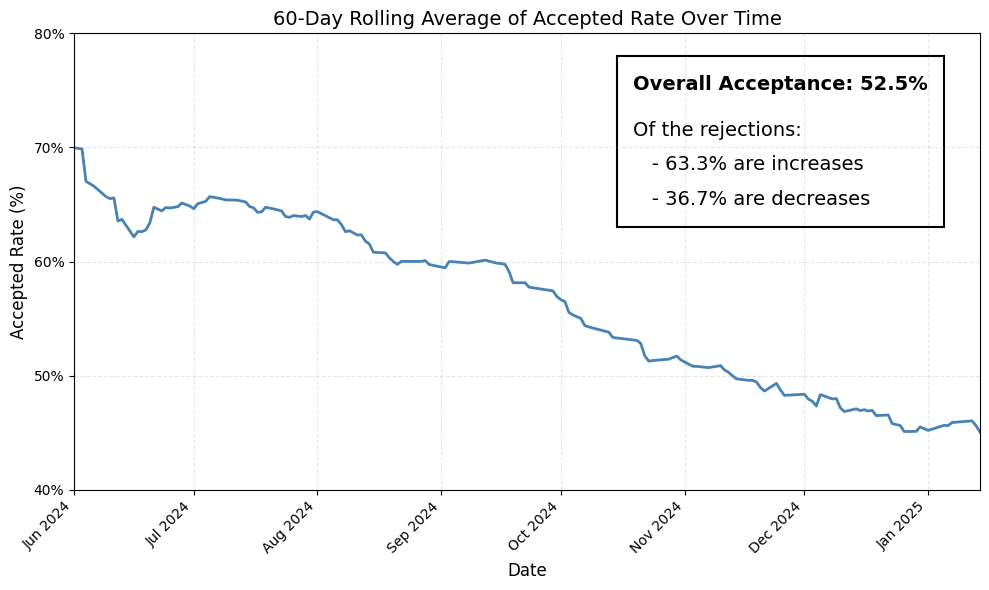

In [ ]:
# Calculate daily average of accepted rate
daily_avg = baseline_merged[baseline_merged['RecommendationDate'] <= pd.to_datetime('2025-02-01')].groupby('RecommendationDate')['accepted_range'].mean()

# Calculate rolling average of accepted rate over time
rolling_avg = daily_avg.rolling(window=60, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_avg, color='steelblue', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accepted Rate (%)', fontsize=12)
plt.title('60-Day Rolling Average of Accepted Rate Over Time', fontsize=14)

# Add text with rectangle around it
text1 = plt.text(x=pd.to_datetime('2024-11-25'), y=0.75, s="Overall Acceptance: 52.5%", size=14, weight="bold", horizontalalignment="center")
text2 = plt.text(x=pd.to_datetime('2024-10-19'), y=0.71, s="Of the rejections:", size=14, horizontalalignment="left")
text3 = plt.text(x=pd.to_datetime('2024-10-19'), y=0.68, s="   - 63.3% are increases", size=14, horizontalalignment="left")
text4 = plt.text(x=pd.to_datetime('2024-10-19'), y=0.65, s="   - 36.7% are decreases", size=14, horizontalalignment="left")


# Add a big rectangle around all the text
plt.gca().add_patch(plt.Rectangle((pd.to_datetime('2024-10-15'), 0.63), pd.to_datetime('2025-01-05') - pd.to_datetime('2024-10-15'), 0.15,
                                  fill=False, edgecolor='black', linewidth=1.5))

plt.xlim(pd.to_datetime('2024-06-01'), max(daily_avg.index))
plt.ylim(0.4, 0.8)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], ['40%', '50%', '60%', '70%', '80%'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.style.use('seaborn-v0_8-muted')
plt.tight_layout()
plt.show()

In [53]:
accepted_pct = (baseline_merged['accepted_range']).mean()
accepted_pct = round(accepted_pct * 100, 1)

rejected_inc = (rejections['increase']).mean()
rejected_dec = 1 - rejected_inc


rejected_inc = round(rejected_inc * 100, 1)
rejected_dec = round(rejected_dec * 100, 1)

# Print out values for debugging
print(f"Accepted percentage: {accepted_pct}")
print(f"Rejected Increase percentage: {rejected_inc}")
print(f"Rejected Decrease percentage: {rejected_dec}")

Accepted percentage: 52.5
Rejected Increase percentage: 63.3
Rejected Decrease percentage: 36.7


In [54]:
by_unitgroup = baseline_merged.groupby('FloorPlanGroupName').agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

by_unitgroup = by_unitgroup[by_unitgroup['count'] > 50]

# Create a GT object
table = GT(by_unitgroup[['FloorPlanGroupName', 'acceptance_rate', 'median_adjustment']])

table = (
    table
    .cols_label(FloorPlanGroupName = md("**Unit Group**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Unit Group")
    .fmt_currency(columns = 2)
    .fmt_percent(columns = 1)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=   FloorPlanGroupName  acceptance_rate  median_adjustment
0                 2x2         0.600679           4.511061
1               2x1.5         0.577320          -1.280355
2                 3x2         0.558180          24.295654
3                 1x1         0.527410           8.047323
7               1x1.5         0.486842          42.224942
8               3x2.5         0.444444          12.943115
9               2x2.5         0.440594          39.602690
10                2x1         0.438776          35.514730
14                0x1         0.367403          35.458035
15                3x3         0.333333          -9.713135, _body=<great_tables._gt_data.Body object at 0x000002A8097345D0>, _boxhead=Boxhead([ColInfo(var='FloorPlanGroupName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Unit Group**'), column_align='left', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A809AF0490>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Unit Group', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=6, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=7, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=8, colnum=None, styles=[Cell

In [ ]:
phoenix_baseline = baseline_merged[(baseline_merged['MarketName'] == 'Phoenix-Mesa-Scottsdale, AZ')]

# display(fort_worth_baseline)

phoenix_by_unitgroup = phoenix_baseline.groupby('FloorPlanGroupName').agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

# Create a GT object
table = GT(phoenix_by_unitgroup[['FloorPlanGroupName', 'count', 'acceptance_rate', 'median_adjustment']])

table = (
    table
    .cols_label(FloorPlanGroupName = md("**Unit Group**"),
                count = md("**Total Inputs**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Unit Group - Phoenix Market")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=  FloorPlanGroupName  count  acceptance_rate  median_adjustment
0                2x2     52         0.519231          29.165658
1              2x1.5      4         0.500000          36.488037
2                3x2     26         0.461538          54.292097
3                1x1     63         0.428571          15.295274
4              1x1.5      5         0.200000         114.516439
5                2x1     23         0.086957         106.582316, _body=<great_tables._gt_data.Body object at 0x000002A80ECB7590>, _boxhead=Boxhead([ColInfo(var='FloorPlanGroupName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Unit Group**'), column_align='left', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Total Inputs**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A80ED7E950>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Unit Group - Fort Worth Market', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='FloorPlanGroupName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x000002A80ECB46D0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002A809ECDE50>, <great_tables._gt_data.FormatInfo object at 0x000002A80DE948D0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInf

In [56]:
by_rm = baseline_merged.groupby(['MarketName']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()


display(by_rm)

,MarketName,count,acceptance_rate,median_adjustment
0,"Boise City, ID",9,0.777778,0.246413
1,"West Palm Beach-Boca Raton-Delray Beach, FL",80,0.687500,-0.349835
2,"Birmingham-Hoover, AL",6,0.666667,0.294226
3,"Nashville-Davidson--Murfreesboro--Franklin, TN",179,0.659218,0.226737
4,"Orlando-Kissimmee-Sanford, FL",433,0.621247,-0.054622
5,"Charlotte-Concord-Gastonia, NC-SC",943,0.580064,4.013690
6,"San Antonio-New Braunfels, TX",36,0.555556,23.235111
7,"Raleigh/Durham, NC",770,0.553247,18.450335
8,"Tampa-St. Petersburg-Clearwater, FL",101,0.544554,34.477714
9,"Miami-Miami Beach-Kendall, FL",63,0.539683,59.399577


In [57]:
example_comments = baseline_merged[baseline_merged['ChangeReason'] == 'Other Action taken (see comment)'].dropna(subset='Comment').sample(15)['Comment']

# Save comments to a text file with one observation per line and no index
with open('figures/example_comments.txt', 'w') as f:
    for comment in example_comments:
        f.write(comment + '\n')

In [58]:
by_property = baseline_merged.groupby(['AssetName', 'User']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

by_property = by_property[by_property['count'] > 20]

# Calculate the overall mean acceptance rate
overall_mean_acceptance_rate = baseline_merged['accepted_range'].mean()

# Function to perform the hypothesis test
def perform_hypothesis_test(asset_name, overall_mean):
    # Get the acceptance rates for the current asset
    asset_data = baseline_merged[baseline_merged['AssetName'] == asset_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(asset_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(asset_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test


# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_property['p_value'] = by_property['AssetName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_property['is_significant'] = by_property['p_value'] < 0.05

by_property = by_property[['AssetName', 'User', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_properties = by_property[by_property['is_significant']]

below_average_properties = significant_properties[significant_properties['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_properties = below_average_properties.drop(columns=['count', 'p_value', 'is_significant']).tail(10)

# Create a GT object
table = GT(below_average_properties)

table = (
    table
    .cols_label(AssetName = md("**Property**"),
                User = md("**RM**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Property",
                subtitle = "(Properties with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2, decimals=1)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=                      AssetName           User  acceptance_rate  \
239      Cortland Congress Park  Joshua Bivens         0.323529   
240     Cortland Cary - Phase 1  Melissa Jones         0.302632   
241         Cortland at Coalton  Joshua Bivens         0.300000   
246           Cortland Cap Hill  Joshua Bivens         0.282051   
249  Cortland Rosslyn - Phase 2  Melissa Jones         0.272727   
251         Cortland West Plano     Ruchi Naik         0.269231   
252    Cortland Covington Ridge  Joshua Bivens         0.266667   
265     Cortland at Twin Creeks     Ruchi Naik         0.222222   
268             Cortland at P83  Joshua Bivens         0.200000   
282          Cortland Northlake  Melissa Jones         0.126761   

     median_adjustment  
239          84.331189  
240          58.989592  
241          94.634572  
246          88.080363  
249          82.245959  
251          34.712725  
252          72.305000  
265          56.486410  
268         -25.196411  
282          83.292485  , _body=<great_tables._gt_data.Body object at 0x000002A809ADD6D0>, _boxhead=Boxhead([ColInfo(var='AssetName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Property**'), column_align='left', column_width=None), ColInfo(var='User', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**RM**'), column_align='left', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A80AAD0810>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Property', subtitle='(Properties with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=6, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, tr

In [89]:
denver_properties = baseline_merged.groupby(['MarketName', 'AssetName', 'User']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

denver_properties = denver_properties[denver_properties['MarketName'] == 'Denver-Aurora-Lakewood, CO']

# Create a GT object
table = GT(denver_properties)

table = (
    table
    .cols_hide(['MarketName', 'User'])
    .cols_label(AssetName = md("**Property**"),
                count = md("**# Inputs**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = md("**Denver Market**"))
    .fmt_currency(columns = 5)
    .fmt_percent(columns = 4, decimals=1)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=                     MarketName                           AssetName  \
87   Denver-Aurora-Lakewood, CO            Cortland on Cherry Creek   
103  Denver-Aurora-Lakewood, CO                  Cortland Flatirons   
125  Denver-Aurora-Lakewood, CO               Cortland Gateway Park   
127  Denver-Aurora-Lakewood, CO            Cortland Belmar Phase II   
150  Denver-Aurora-Lakewood, CO                 Cortland Broomfield   
178  Denver-Aurora-Lakewood, CO             Cortland Belmar Phase I   
224  Denver-Aurora-Lakewood, CO       Mint Urban Infinity - Phase 2   
226  Denver-Aurora-Lakewood, CO                   Cortland on Blake   
239  Denver-Aurora-Lakewood, CO              Cortland Congress Park   
241  Denver-Aurora-Lakewood, CO                 Cortland at Coalton   
246  Denver-Aurora-Lakewood, CO                   Cortland Cap Hill   
248  Denver-Aurora-Lakewood, CO                Cortland Westminster   
249  Denver-Aurora-Lakewood, CO       Mint Urban Infinity - Phase 1   
252  Denver-Aurora-Lakewood, CO            Cortland Covington Ridge   
267  Denver-Aurora-Lakewood, CO  Cortland Alameda Station - Phase 1   

              User  count  acceptance_rate  median_adjustment  
87   Joshua Bivens     29         0.655172           6.819987  
103  Joshua Bivens     33         0.606061          52.389935  
125  Joshua Bivens     48         0.562500           1.501918  
127  Joshua Bivens     18         0.555556          15.804276  
150  Joshua Bivens     35         0.514286          45.555318  
178  Joshua Bivens     17         0.470588          49.850098  
224  Joshua Bivens      9         0.333333          39.766357  
226  Joshua Bivens     15         0.333333          43.938324  
239  Joshua Bivens     34         0.323529          84.331189  
241  Joshua Bivens     50         0.300000          94.634572  
246  Joshua Bivens     39         0.282051          88.080363  
248  Joshua Bivens     11         0.272727          62.933018  
249  Joshua Bivens     11         0.272727          42.743828  
252  Joshua Bivens     30         0.266667          72.305000  
267  Joshua Bivens     20         0.200000          39.697955  , _body=<great_tables._gt_data.Body object at 0x000002A80ED2B010>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.hidden: 4>, column_label='MarketName', column_align='left', column_width=None), ColInfo(var='AssetName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Property**'), column_align='left', column_width=None), ColInfo(var='User', type=<ColInfoTypeEnum.hidden: 4>, column_label='User', column_align='left', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Inputs**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A80ECBAB90>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Denver Market**'), subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='Market

In [59]:
baseline_merged['AcquisitionDate_numeric'] = pd.to_datetime(baseline_merged['AcquisitionDate']).astype(int) / 10**9

# Perform the aggregation
by_market = baseline_merged.groupby(['MarketName']).agg(
    count=('accepted', 'count'),
    acceptance_rate=('accepted_range', 'mean'),
    num_assets=('AssetName', 'nunique'),
    acquisition_date_numeric=('AcquisitionDate_numeric', 'min'),
    median_adjustment=('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

# Convert the numeric values back to dates
by_market['acquisition_date'] = pd.to_datetime(by_market['acquisition_date_numeric'], unit='s')
by_market.drop(columns=['acquisition_date_numeric'], inplace=True)

# Function to perform the hypothesis test
def perform_hypothesis_test(market_name, overall_mean):
    # Get the acceptance rates for the current market
    market_data = baseline_merged[baseline_merged['MarketName'] == market_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(market_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(market_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test

# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_market['p_value'] = by_market['MarketName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_market['is_significant'] = by_market['p_value'] < 0.05

by_market = by_market[['MarketName', 'count', 'num_assets', 'acquisition_date', 'acceptance_rate', 'median_adjustment', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_markets = by_market[by_market['is_significant']]

below_average_markets = significant_markets[significant_markets['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_markets = below_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(below_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

# Display the table
# table.save('figures/low_acc_bymarket.png')


GT(_tbl_data=                     MarketName  num_assets acquisition_date  acceptance_rate  \
20   Denver-Aurora-Lakewood, CO          15       2017-12-19         0.413534   
21     Fort Worth-Arlington, TX          11       2014-02-07         0.410405   
24                   Tucson, AZ           5       2021-08-16         0.362319   
25  Phoenix-Mesa-Scottsdale, AZ          14       2019-03-11         0.310638   

    median_adjustment  
20          49.369019  
21          42.446230  
24          38.152918  
25          37.655504  , _body=<great_tables._gt_data.Body object at 0x000002A809ADF450>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A8097C2DD0>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle='(Markets with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x000002A80989C050>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002A8098DAC10>, <great_tables._gt_data.FormatInfo object at 0x000002A8098DBA10>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-ser

In [65]:
# Create a GT object
table = GT(by_market[by_market['count'] > 80].drop(columns=['p_value', 'is_significant', 'acquisition_date']))

table = (
    table
    .cols_move(columns="acceptance_rate", after="MarketName")
    .cols_label(MarketName = md("**Market**"),
                count = md("**Total Inputs**"),
                num_assets = md("**# Assets**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3, decimals=1)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

# Display the table
# table.save('figures/acc_bymarket.png')

GT(_tbl_data=                                        MarketName  count  num_assets  \
3   Nashville-Davidson--Murfreesboro--Franklin, TN    179           3   
4                    Orlando-Kissimmee-Sanford, FL    433          14   
5                Charlotte-Concord-Gastonia, NC-SC    943          11   
7                               Raleigh/Durham, NC    770          11   
8              Tampa-St. Petersburg-Clearwater, FL    101          14   
11               Atlanta-Sandy Springs-Roswell, GA   1509          36   
12            Houston-The Woodlands-Sugar Land, TX    169          13   
13                                    Columbus, OH    998          14   
14                         Dallas-Plano-Irving, TX    616          31   
18    Washington-Arlington-Alexandria, DC-VA-MD-WV    154           5   
20                      Denver-Aurora-Lakewood, CO    399          15   
21                        Fort Worth-Arlington, TX    173          11   
25                     Phoenix-Mesa-Scottsdale, AZ    235          14   

    acceptance_rate  median_adjustment  
3          0.659218           0.226737  
4          0.621247          -0.054622  
5          0.580064           4.013690  
7          0.553247          18.450335  
8          0.544554          34.477714  
11         0.524851          28.735490  
12         0.520710           5.682097  
13         0.519038          -0.336809  
14         0.516234          22.944723  
18         0.461039          48.720180  
20         0.413534          49.369019  
21         0.410405          42.446230  
25         0.310638          37.655504  , _body=<great_tables._gt_data.Body object at 0x000002A809E9CE90>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Total Inputs**'), column_align='right', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A809E0ED90>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=N

In [61]:
above_average_markets = significant_markets[significant_markets['acceptance_rate'] > overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
above_average_markets = above_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(above_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

# table.save('figures/high_acc_bymarket.png')


GT(_tbl_data=                                       MarketName  num_assets  \
1     West Palm Beach-Boca Raton-Delray Beach, FL           6   
3  Nashville-Davidson--Murfreesboro--Franklin, TN           3   
4                   Orlando-Kissimmee-Sanford, FL          14   
5               Charlotte-Concord-Gastonia, NC-SC          11   

  acquisition_date  acceptance_rate  median_adjustment  
1       2020-07-23         0.687500          -0.349835  
3       2021-09-16         0.659218           0.226737  
4       2018-07-17         0.621247          -0.054622  
5       2017-09-29         0.580064           4.013690  , _body=<great_tables._gt_data.Body object at 0x000002A8022746D0>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000002A802E40BD0>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle='(Markets with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x000002A809867090>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002A8022F4810>, <great_tables._gt_data.FormatInfo object at 0x000002A8022F4E50>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', '

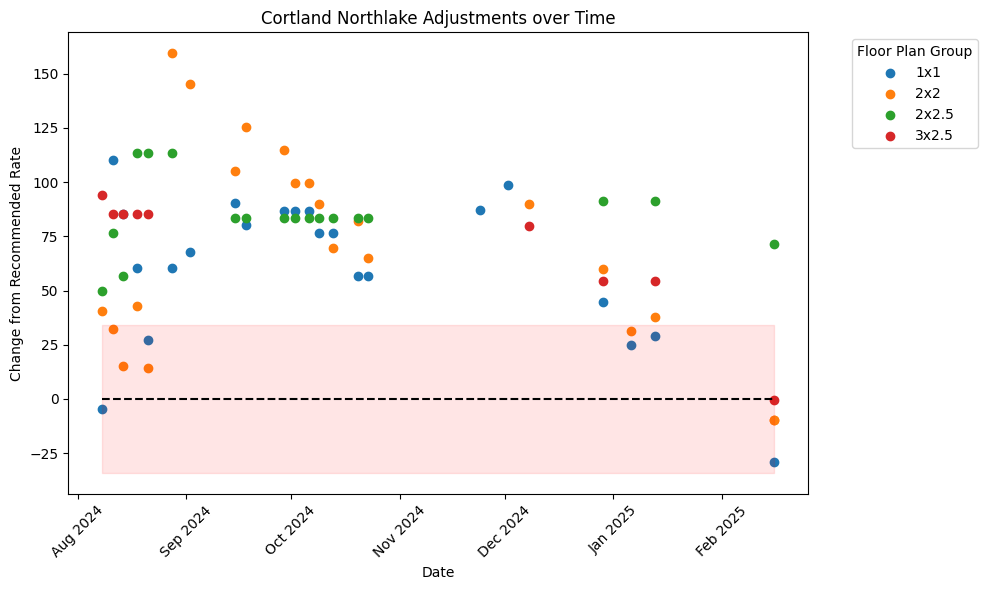

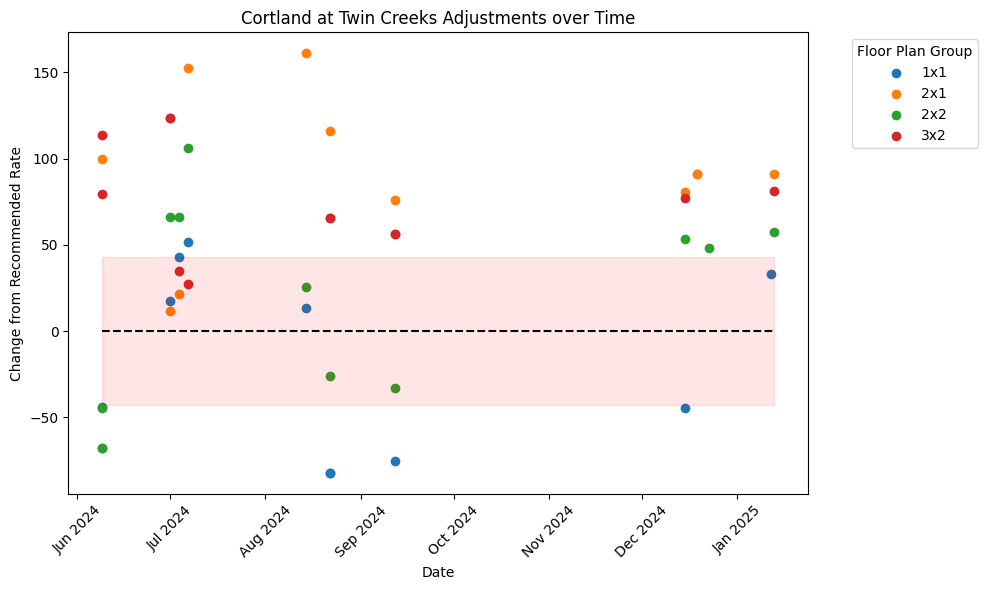

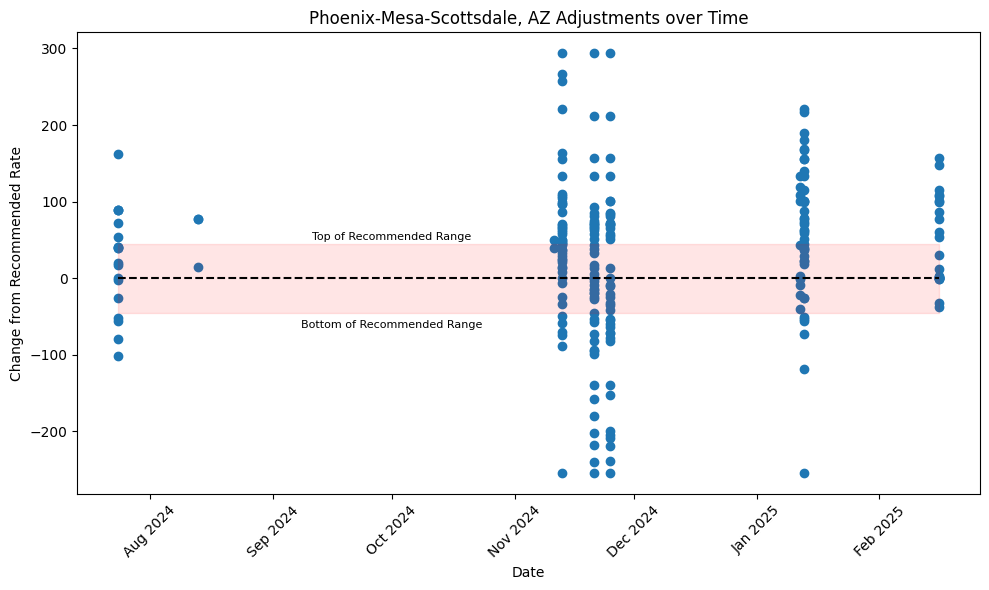

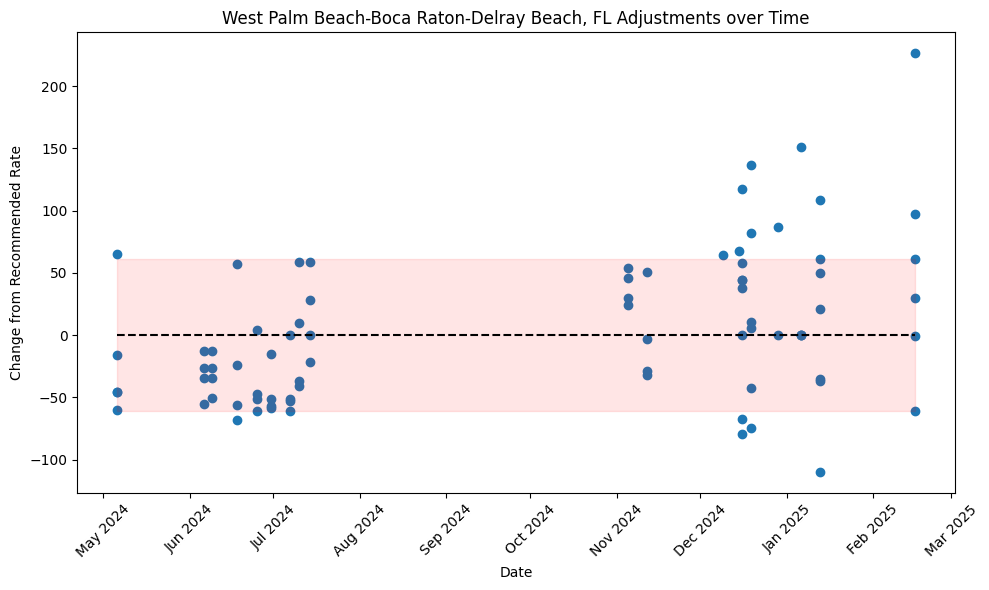

In [91]:
def get_adj_over_time(asset_name=None, market_name=None):

    if asset_name:
        filtered = baseline_merged[baseline_merged['AssetName'] == asset_name]
    elif market_name:
        filtered = baseline_merged[baseline_merged['MarketName'] == market_name]

    filtered = filtered.sort_values('RecommendationDate').reset_index()

    avg_range = (filtered['recc_rate'] - filtered['recc_rate_lower']).mean()

    def sort_key(floor_plan):
        bedrooms, bathrooms = floor_plan.split('x')
        return (float(bedrooms), float(bathrooms)) 

    # Generate unique categories and sort them
    unique_categories = sorted(filtered['FloorPlanGroupName'].unique(), key=sort_key)
    palette = dict(zip(unique_categories, sns.color_palette("tab10", len(unique_categories))))

    # Create the scatter plot with categorical colors
    fig, ax = plt.subplots(figsize=(10,6))

    for category, color in palette.items():
        subset = filtered[filtered['FloorPlanGroupName'] == category]
        if asset_name:
            ax.scatter(subset['RecommendationDate'], subset['Diff'], color=color, label=category)
        elif market_name:
            ax.scatter(subset['RecommendationDate'], subset['Diff'], color='#1f77b4')

    # Add legend
    if asset_name:
        ax.legend(title="Floor Plan Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xlabel("Date")
    plt.ylabel("Change from Recommended Rate")

    if asset_name:
        plt.title(f"{asset_name} Adjustments over Time")
    elif market_name:
        plt.title(f"{market_name} Adjustments over Time")
    
    plt.fill_between(filtered['RecommendationDate'], -avg_range, avg_range, color='red', alpha=0.1)
    plt.hlines(0, min(filtered['RecommendationDate']), max(filtered['RecommendationDate']), linestyles="dashed", colors="black")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    if market_name == "Phoenix-Mesa-Scottsdale, AZ":
        plt.text(x=pd.to_datetime('2024-10-01'), y=avg_range + 5, s="Top of Recommended Range", size=8, ha='center')
        plt.text(x=pd.to_datetime('2024-10-01'), y=-avg_range - 20, s="Bottom of Recommended Range", size=8, ha='center')
    plt.style.use('seaborn-v0_8-muted')
    plt.tight_layout()
    if asset_name:
        plt.savefig(f'figures/adj_over_time/{asset_name}', )
    elif market_name:
        plt.savefig(f'figures/adj_over_time/{market_name}')
    
    plt.show()
    

get_adj_over_time(asset_name="Cortland Northlake")
get_adj_over_time(asset_name="Cortland at Twin Creeks")
get_adj_over_time(market_name="Phoenix-Mesa-Scottsdale, AZ")
get_adj_over_time(market_name="West Palm Beach-Boca Raton-Delray Beach, FL")
# get_adj_over_time(market_name="Denver-Aurora-Lakewood, CO")
# get_adj_over_time(market_name="Colorado Springs, CO")